Previously, we considered the overall trend of the price changes for the various cryptocurrencies being analyzed in this project. We determined there is a significant correlation between the different coins, and that correlation does not have any kind of lag that could have influenced the chronology of how we predict prices for specific coins. 

Now, we will explore other aspects of tyhe data set and ask the following questions: 

1. Is the volume of transaction a useful feature in predicting future price? When previously engaged in the trading of these coins, I came across several bot signalers that would use a sudden increase in trading volume to predict that the price of a certain coin is about to increase ( or vice versa for a decrease in volume). 

2. In the base level of our model, we will be using a LSTM that is fed features on the past 6 time periods (t-5 to t) to predict the price at t + 4. However, I would like to explore how to pre-process the base level data (price, volume, high, lows ) into indicators that could capture deeper insights such as momentum that could indicate that a coin is set for a change in behavior. In this exploration, we will calculate such indicators and check their validity as valuable features. 

3. I will also try to compute indicators for evaulation of my algorithm. Since we are dealing with a time series with very pronounced trends, it will be useful to understand just how many of our t + 3 prices are an increase from our t prices. This will speak to the imbalance in our data and set a standard for our model. I will also look to measure for measures of volatility. 

## Part 1

In [1]:
%store -r df_prices_log_return
%store -r df_volumes
%store -r df_prices

import numpy as np
import pandas as pd

In [4]:
df_prices_log_return.head()

,btc price,eth price,ltc price,xrp price,bch price,eos price
Time,,,,,,
2018-01-02 04:00:00,0.009390,0.011206,0.011791,0.086561,0.146259,0.020447
2018-01-02 08:00:00,-0.004421,0.084178,0.071016,-0.052158,0.023015,0.019772
2018-01-02 12:00:00,0.003075,0.029938,0.002705,0.023322,-0.008595,0.170451
2018-01-02 16:00:00,0.012944,0.003289,0.001827,0.019976,0.021477,-0.027104
2018-01-02 20:00:00,0.013289,0.019567,0.040010,0.032303,0.043982,0.018606


In [6]:
df_corr = pd.concat([df_prices_log_return['btc price'], df_volumes['btc volume']], axis=1).corr()
df_corr

,btc price,btc volume
btc price,1.000000,-0.082436
btc volume,-0.082436,1.000000


In [7]:
for i in range(5):
    df_temp = df_prices_log_return['btc price'].shift(-i)
    df_corr = pd.concat([df_temp, df_volumes['btc volume']], axis=1)
    print(df_corr.corr().iloc[1,0])

-0.08243610198909146
-0.06553421924099585
-0.014301227327168277
-0.0098813910680832
-0.02129338327272793


Its possible that changes in volume are more indicative than the actual values (if actual values have persisted for a while then that does not serve to illustrate any new behavior) Lets try that now:

In [8]:
btc_volume_change = df_volumes['btc volume'].pct_change()[1:]
df_prices_log_return = df_prices_log_return[1:]
for i in range(5):
    df_temp = df_prices_log_return['btc price'].shift(-i)
    df_corr = pd.concat([df_temp, btc_volume_change], axis=1)
    print(df_corr.corr().iloc[1,0])

0.004440817269253672
-0.01679854400809369
-0.005270452179741017
0.009538336371037338
-0.007909123183181852


There does not seem to be any significant correlation between volume and price changes. To further test this hypothesis, we will test for correlation of volume changes vs. absolute values of price change. This is based on the idea that volume goes up when the people are buying because there is a general sentiment of prices going up, or perhaps selling because of an opposite sentiment. 

In [11]:
btc_volume_change_abs = abs(btc_volume_change)
btc_volume_abs = abs(df_volumes['btc volume'])

for i in range(5):
    df_temp = df_prices_log_return['btc price'].shift(-i)
    df_corr = pd.concat([df_temp, btc_volume_change_abs], axis=1)
    print(df_corr.corr().iloc[1,0])
    
print()

for i in range(5):
    df_temp = df_prices_log_return['btc price'].shift(-i)
    df_corr = pd.concat([df_temp, btc_volume_abs], axis=1)
    print(df_corr.corr().iloc[1,0])    

0.002604637985949765
-0.012099381029872085
-0.0014074518059388138
0.0034988367225429677
-0.0070332078282242146

-0.082587853991549
-0.06547616490952479
-0.014348635610016829
-0.01007630249361614
-0.02149579810337198


The best correlation here is the initial value of the volume, predicting the next periods price change. 

In [34]:

spans = [(1,2), (2,4), (4,8), (6,12), (12, 26)]

for j in spans:
    exp1 = df_prices['btc price'].ewm(span=j[0], adjust=False).mean()
    exp2 = df_prices['btc price'].ewm(span=j[1], adjust=False).mean()
    macd = exp1- exp2
    print(j, ':')
    for i in range(5):
        print(pd.concat([macd, df_prices_log_return['btc price'].shift(-i)], axis=1).corr().iloc[1,0])

(1, 2) :
0.8907121870059544
-0.019322732242691598
0.0030055162496068436
0.024916389198347218
0.11266393902750042
(2, 4) :
0.5842777239679842
0.005259810527298699
0.02991957939666696
0.04657210117654659
0.050513737503753424
(4, 8) :
0.29355703971216573
0.014989446568722508
0.02228266199628294
0.019678976515066126
0.006715946328476881
(6, 12) :
0.18367618197399535
0.013041472071020835
0.015308008023800643
0.011354393849001193
0.0022778649978650325
(12, 26) :
0.0797512691641799
0.014833916358922446
0.015178689268647794
0.013463842577383783
0.010579347123549153


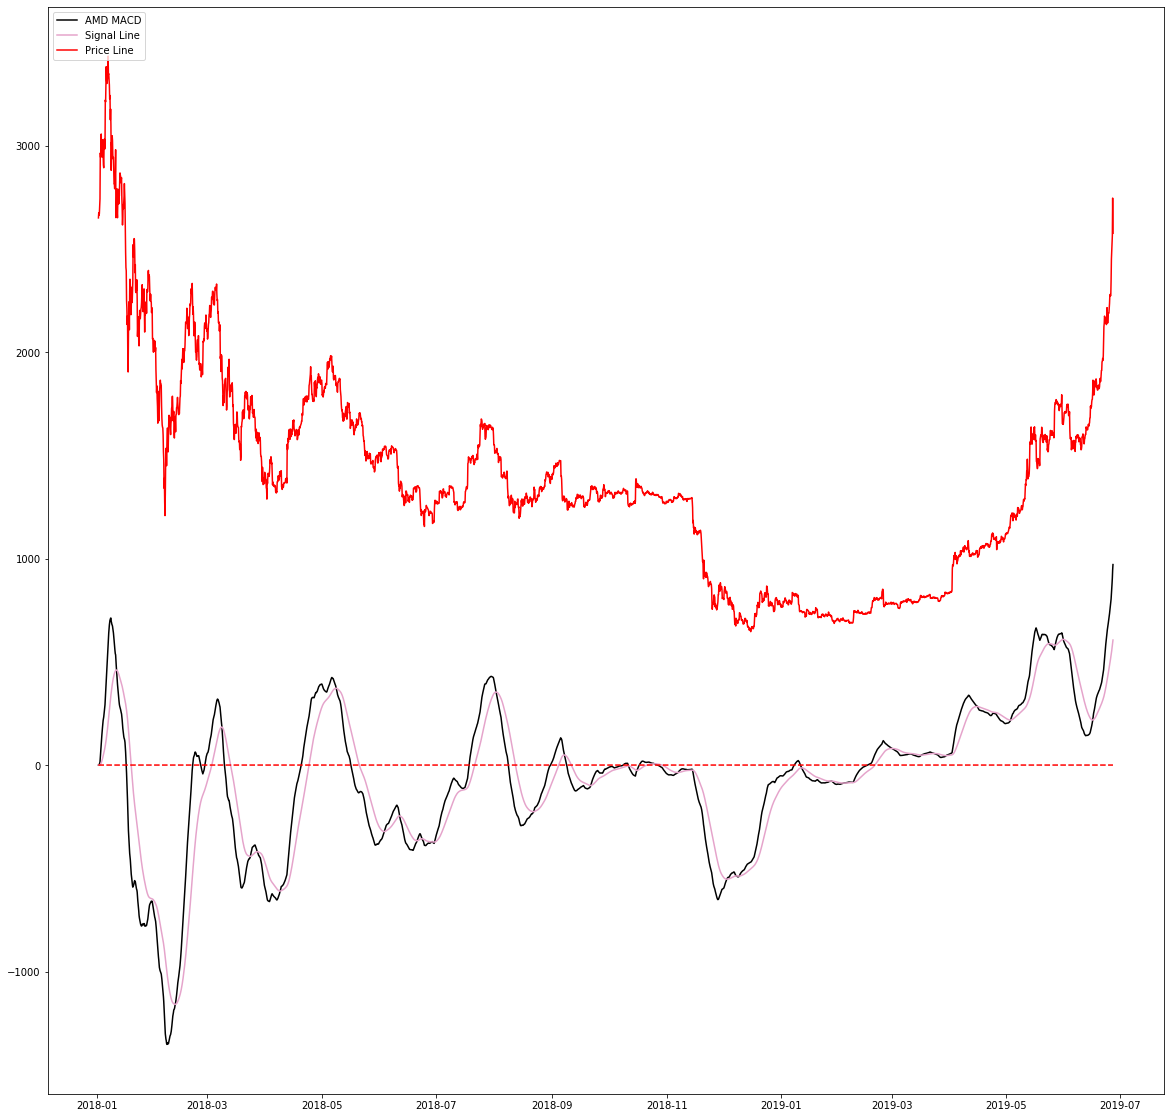

In [113]:
macd = df_prices['btc price'].ewm(span=72, adjust=False).mean() - df_prices['btc price'].ewm(span=156, adjust=False).mean()
signal = macd.ewm(span = 54, adjust = False).mean()

import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.plot(df_prices.index, macd, label='AMD MACD', color = 'black')
plt.plot(df_prices.index, signal, label='Signal Line', color='#E5A4CB')
plt.plot(df_prices.index,df_prices['btc price']/5, label='Price Line', color='red')
hl = [0 for i in df_prices.index]
plt.plot(df_prices.index,hl, 'r--')
plt.legend(loc='upper left')
plt.show()

# fig, ax =plt.subplots(1,2)
# plt.plot(df_prices.index, df_prices['btc price'], label='Signal Line', color='#E5A4CB' ,ax=ax[0])
# plt.plot(df_prices.index, macd, label='AMD MACD', color = '#EBD2BE', ax=ax[1])
# fig.show()

In [114]:
for i in range(5):
    print(pd.concat([macd, df_prices['btc price'].shift(-i)], axis=1).corr().iloc[1,0])
for i in range(1,20,2):  
    print("longer period returns correlation with macd over",i*10,"periods:" , pd.concat([macd, df_prices['btc price'].shift(-10*i) / df_prices['btc price']], axis=1).corr().iloc[1,0])

0.13974131705503298
0.13797492535964181
0.13622923584301083
0.13451232974462868
0.13280360017656737
longer period returns correlation with macd over 10 periods: -0.001466437315729851
longer period returns correlation with macd over 30 periods: -0.031789318204901225
longer period returns correlation with macd over 50 periods: -0.06793072318405163
longer period returns correlation with macd over 70 periods: -0.07853494005476272
longer period returns correlation with macd over 90 periods: -0.08493300704585456
longer period returns correlation with macd over 110 periods: -0.09480321087992344
longer period returns correlation with macd over 130 periods: -0.11744279388522057
longer period returns correlation with macd over 150 periods: -0.12470623980222792
longer period returns correlation with macd over 170 periods: -0.10156828608388446
longer period returns correlation with macd over 190 periods: -0.05469876477131123


In [115]:
macd = df_prices['btc price'].ewm(span=12, adjust=False).mean() - df_prices['btc price'].ewm(span=26, adjust=False).mean()

In [118]:
for i in range(1,20,2):  
    print("shorter period returns correlation with macd over",i,"periods:" , pd.concat([macd, df_prices['btc price'].shift(-i) / df_prices['btc price']], axis=1).corr().iloc[1,0])

shorter period returns correlation with macd over 1 periods: 0.009059661548010868
shorter period returns correlation with macd over 3 periods: 0.018840939711353605
shorter period returns correlation with macd over 5 periods: 0.01836783362292313
shorter period returns correlation with macd over 7 periods: 0.02042069210037474
shorter period returns correlation with macd over 9 periods: 0.029425318285270955
shorter period returns correlation with macd over 11 periods: 0.03311502351105126
shorter period returns correlation with macd over 13 periods: 0.03746913810884495
shorter period returns correlation with macd over 15 periods: 0.04174836245519964
shorter period returns correlation with macd over 17 periods: 0.04502148584434997
shorter period returns correlation with macd over 19 periods: 0.046613896869329846


In [119]:
macd = df_prices['btc price'].ewm(span=2, adjust=False).mean() - df_prices['btc price'].ewm(span=4, adjust=False).mean()
for i in range(1,20,2):  
    print("shorter period returns correlation with macd over",i,"periods:" , pd.concat([macd, df_prices['btc price'].shift(-i) / df_prices['btc price']], axis=1).corr().iloc[1,0])

shorter period returns correlation with macd over 1 periods: 0.0021461098526998497
shorter period returns correlation with macd over 3 periods: 0.044571508213758326
shorter period returns correlation with macd over 5 periods: 0.03568025893151855
shorter period returns correlation with macd over 7 periods: -0.013608563381734473
shorter period returns correlation with macd over 9 periods: 0.01373789526144843
shorter period returns correlation with macd over 11 periods: 0.007925652412011581
shorter period returns correlation with macd over 13 periods: 0.005190654510339379
shorter period returns correlation with macd over 15 periods: 0.009680622541438323
shorter period returns correlation with macd over 17 periods: 0.021228476742427116
shorter period returns correlation with macd over 19 periods: 0.020700327854242334


## The MACD is more useful at predicting longer term trend changes, rather than shorter term changes (the MACD is an oscillator and does not give very accurate information if very strong changes) It's important to note that our period here is 4 hours. 

In [122]:
current_1_day_return = df_prices['btc price'] / df_prices['btc price'].shift(6)
current_3_day_return = df_prices['btc price'] / df_prices['btc price'].shift(18)

In [124]:
for i in range(1,20,2):  
    print("looking forward ", i, "periods:")
    print("1DAY", pd.concat([current_1_day_return, df_prices['btc price'].shift(-i) / df_prices['btc price']], axis=1).corr().iloc[1,0])
    print("3DAY", pd.concat([current_3_day_return, df_prices['btc price'].shift(-i) / df_prices['btc price']], axis=1).corr().iloc[1,0])

    

looking forward  1 periods:
1DAY 0.0016453043046381478
3DAY 0.012035857164036759
looking forward  3 periods:
1DAY -0.022332688225825542
3DAY 0.027260747295466948
looking forward  5 periods:
1DAY -0.02598549532044506
3DAY 0.02884981720124974
looking forward  7 periods:
1DAY -0.03749843324579347
3DAY 0.010979138485116481
looking forward  9 periods:
1DAY -0.016127345415531617
3DAY 0.017507610538015316
looking forward  11 periods:
1DAY -0.01761821314072755
3DAY 0.01190781670180309
looking forward  13 periods:
1DAY -0.011914777418337743
3DAY 0.016191844011634232
looking forward  15 periods:
1DAY -0.00034347599926082777
3DAY 0.02353591314510027
looking forward  17 periods:
1DAY 0.013267191100512806
3DAY 0.03393767082327659
looking forward  19 periods:
1DAY 0.006140132514643754
3DAY 0.0392203693613111


Ultimately, this analysis showed us some possible tools we could use to help extract more signal from our dataset. Most features did not offer substantial improvement, but with an alogrithm even a few percentage points of increased accuracy ultimately translates to a substantially improved profitibality. 